#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [2]:
%reset -f
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [3]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [4]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [5]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
125,3,186,porsche,gas,std,two,hatchback,rwd,front,94.50,...,151,mpfi,3.94,3.11,9.50,143,5500,19,27,22018
74,1,?,mercedes-benz,gas,std,two,hardtop,rwd,front,112.00,...,304,mpfi,3.80,3.35,8.00,184,4500,14,16,45400
168,2,134,toyota,gas,std,two,hardtop,rwd,front,98.40,...,146,mpfi,3.62,3.50,9.30,116,4800,24,30,9639


c:  symboling  		 type:  <class 'numpy.int64'>
c:  normalized-losses  		 type:  <class 'str'>
c:  make  		 type:  <class 'str'>
c:  fuel-type  		 type:  <class 'str'>
c:  aspiration  		 type:  <class 'str'>
c:  num-doors  		 type:  <class 'str'>
c:  body-style  		 type:  <class 'str'>
c:  drive-wheels  		 type:  <class 'str'>
c:  engine-location  		 type:  <class 'str'>
c:  wheel-base  		 type:  <class 'numpy.float64'>
c:  length  		 type:  <class 'numpy.float64'>
c:  width  		 type:  <class 'numpy.float64'>
c:  height  		 type:  <class 'numpy.float64'>
c:  weight  		 type:  <class 'numpy.int64'>
c:  engine-type  		 type:  <class 'str'>
c:  num-cylinders  		 type:  <class 'str'>
c:  engine-size  		 type:  <class 'numpy.int64'>
c:  fuel-system  		 type:  <class 'str'>
c:  bore  		 type:  <class 'str'>
c:  stroke  		 type:  <class 'str'>
c:  compression-ratio  		 type:  <class 'numpy.float64'>
c:  horsepower  		 type:  <class 'str'>
c:  peak-rpm  		 type:  <class 'str'>
c:  city-mpg  		 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5222a1fa50>,
      dtype=object)

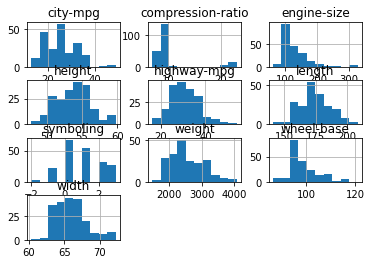

In [6]:
for c in car_data.columns:
  print("c: ", c, " \t\t type: ", type(car_data[c][1]))
car_data.hist()

In [7]:
numeric_feature_names = []
categorical_feature_names = []

In [8]:
def look_at_feature(feature):
  feature.hist()
  print(feature.head())
  print(feature.tail())
  return feature.describe()

In [9]:
for c in car_data.columns:
  print(f"look_at_feature(car_data[\"{c}\"])")

look_at_feature(car_data["symboling"])
look_at_feature(car_data["normalized-losses"])
look_at_feature(car_data["make"])
look_at_feature(car_data["fuel-type"])
look_at_feature(car_data["aspiration"])
look_at_feature(car_data["num-doors"])
look_at_feature(car_data["body-style"])
look_at_feature(car_data["drive-wheels"])
look_at_feature(car_data["engine-location"])
look_at_feature(car_data["wheel-base"])
look_at_feature(car_data["length"])
look_at_feature(car_data["width"])
look_at_feature(car_data["height"])
look_at_feature(car_data["weight"])
look_at_feature(car_data["engine-type"])
look_at_feature(car_data["num-cylinders"])
look_at_feature(car_data["engine-size"])
look_at_feature(car_data["fuel-system"])
look_at_feature(car_data["bore"])
look_at_feature(car_data["stroke"])
look_at_feature(car_data["compression-ratio"])
look_at_feature(car_data["horsepower"])
look_at_feature(car_data["peak-rpm"])
look_at_feature(car_data["city-mpg"])
look_at_feature(car_data["highway-mpg"])
look_at_feat

16     0
24     1
113    0
53     1
125    3
Name: symboling, dtype: int64
0      3
103    0
91     1
43     0
27     1
Name: symboling, dtype: int64


count   205.00
mean      0.83
std       1.25
min      -2.00
25%       0.00
50%       1.00
75%       2.00
max       3.00
Name: symboling, dtype: float64

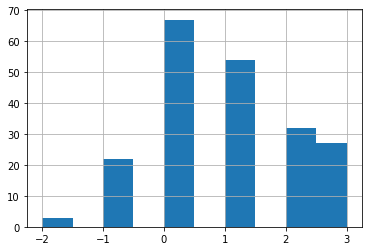

In [10]:
numeric_feature_names.append("symboling")
look_at_feature(car_data["symboling"])

16       ?
24     148
113      ?
53     113
125    186
Name: normalized-losses, dtype: object
0        ?
103    108
91     128
43       ?
27     148
Name: normalized-losses, dtype: object


count     205
unique     52
top         ?
freq       41
Name: normalized-losses, dtype: object

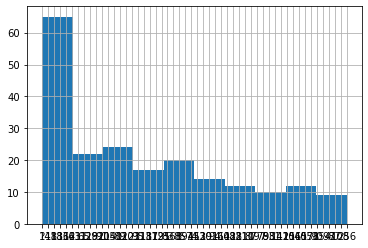

In [11]:
numeric_feature_names.append("normalized-losses")
look_at_feature(car_data["normalized-losses"])

16         bmw
24       dodge
113     peugot
53       mazda
125    porsche
Name: make, dtype: object
0      alfa-romero
103         nissan
91          nissan
43           isuzu
27           dodge
Name: make, dtype: object


count        205
unique        22
top       toyota
freq          32
Name: make, dtype: object

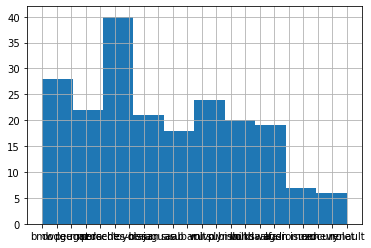

In [12]:
categorical_feature_names.append("make")
look_at_feature(car_data["make"])


16     gas
24     gas
113    gas
53     gas
125    gas
Name: fuel-type, dtype: object
0      gas
103    gas
91     gas
43     gas
27     gas
Name: fuel-type, dtype: object


count     205
unique      2
top       gas
freq      185
Name: fuel-type, dtype: object

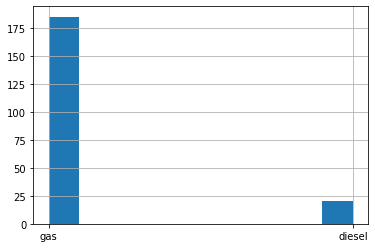

In [13]:
categorical_feature_names.append("fuel-type")

look_at_feature(car_data["fuel-type"])


16     std
24     std
113    std
53     std
125    std
Name: aspiration, dtype: object
0        std
103      std
91       std
43       std
27     turbo
Name: aspiration, dtype: object


count     205
unique      2
top       std
freq      168
Name: aspiration, dtype: object

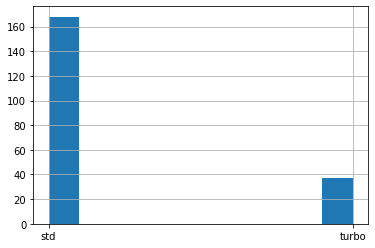

In [14]:
categorical_feature_names.append("aspiration")

look_at_feature(car_data["aspiration"])


16      two
24     four
113    four
53     four
125     two
Name: num-doors, dtype: object
0       two
103    four
91      two
43     four
27        ?
Name: num-doors, dtype: object


count      205
unique       3
top       four
freq       114
Name: num-doors, dtype: object

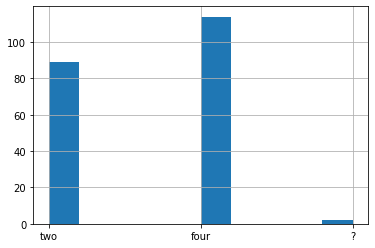

In [15]:
categorical_feature_names.append("num-doors")

look_at_feature(car_data["num-doors"])


16         sedan
24     hatchback
113        wagon
53         sedan
125    hatchback
Name: body-style, dtype: object
0      convertible
103          sedan
91           sedan
43           sedan
27           sedan
Name: body-style, dtype: object


count       205
unique        5
top       sedan
freq         96
Name: body-style, dtype: object

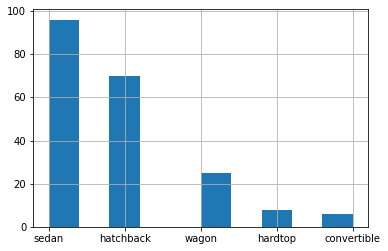

In [16]:
categorical_feature_names.append("body-style")
look_at_feature(car_data["body-style"])


16     rwd
24     fwd
113    rwd
53     fwd
125    rwd
Name: drive-wheels, dtype: object
0      rwd
103    fwd
91     fwd
43     rwd
27     fwd
Name: drive-wheels, dtype: object


count     205
unique      3
top       fwd
freq      120
Name: drive-wheels, dtype: object

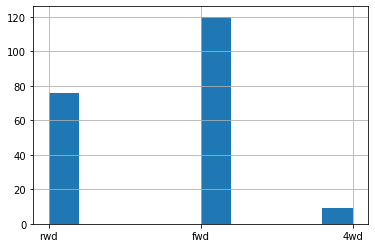

In [17]:
categorical_feature_names.append("drive-wheels")

look_at_feature(car_data["drive-wheels"])


16     front
24     front
113    front
53     front
125    front
Name: engine-location, dtype: object
0      front
103    front
91     front
43     front
27     front
Name: engine-location, dtype: object


count       205
unique        2
top       front
freq        202
Name: engine-location, dtype: object

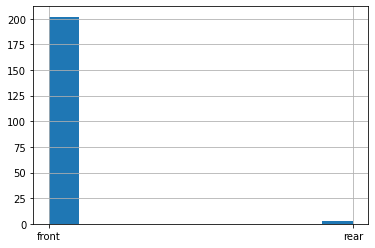

In [18]:
categorical_feature_names.append("engine-locations")

look_at_feature(car_data["engine-location"])


16    103.50
24     93.70
113   114.20
53     93.10
125    94.50
Name: wheel-base, dtype: float64
0      88.60
103   100.40
91     94.50
43     94.30
27     93.70
Name: wheel-base, dtype: float64


count   205.00
mean     98.76
std       6.02
min      86.60
25%      94.50
50%      97.00
75%     102.40
max     120.90
Name: wheel-base, dtype: float64

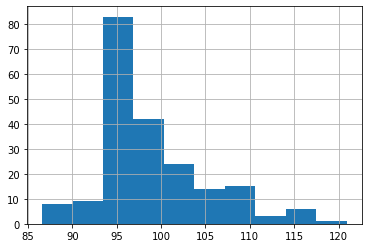

In [19]:

numeric_feature_names.append("wheel-bases")
look_at_feature(car_data["wheel-base"])


16    193.80
24    157.30
113   198.90
53    166.80
125   168.90
Name: length, dtype: float64
0     168.80
103   184.60
91    165.30
43    170.70
27    157.30
Name: length, dtype: float64


count   205.00
mean    174.05
std      12.34
min     141.10
25%     166.30
50%     173.20
75%     183.10
max     208.10
Name: length, dtype: float64

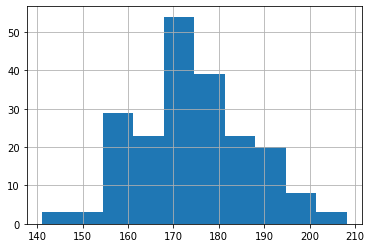

In [20]:

numeric_feature_names.append("length")
look_at_feature(car_data["length"])


16    67.90
24    63.80
113   68.40
53    64.20
125   68.30
Name: width, dtype: float64
0     64.10
103   66.50
91    63.80
43    61.80
27    63.80
Name: width, dtype: float64


count   205.00
mean     65.91
std       2.15
min      60.30
25%      64.10
50%      65.50
75%      66.90
max      72.30
Name: width, dtype: float64

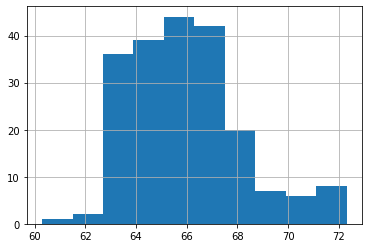

In [21]:

numeric_feature_names.append("width")
look_at_feature(car_data["width"])


16    53.70
24    50.60
113   56.70
53    54.10
125   50.20
Name: height, dtype: float64
0     48.80
103   55.10
91    54.50
43    53.50
27    50.60
Name: height, dtype: float64


count   205.00
mean     53.72
std       2.44
min      47.80
25%      52.00
50%      54.10
75%      55.50
max      59.80
Name: height, dtype: float64

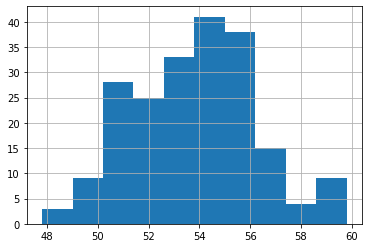

In [22]:

numeric_feature_names.append("height")
look_at_feature(car_data["height"])


16     3380
24     1967
113    3285
53     1945
125    2778
Name: weight, dtype: int64
0      2548
103    3060
91     1918
43     2337
27     2191
Name: weight, dtype: int64


count    205.00
mean    2555.57
std      520.68
min     1488.00
25%     2145.00
50%     2414.00
75%     2935.00
max     4066.00
Name: weight, dtype: float64

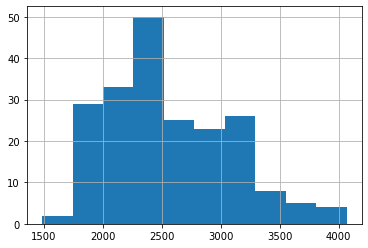

In [23]:

numeric_feature_names.append("weight")
look_at_feature(car_data["weight"])


16     ohc
24     ohc
113      l
53     ohc
125    ohc
Name: engine-type, dtype: object
0      dohc
103    ohcv
91      ohc
43      ohc
27      ohc
Name: engine-type, dtype: object


count     205
unique      7
top       ohc
freq      148
Name: engine-type, dtype: object

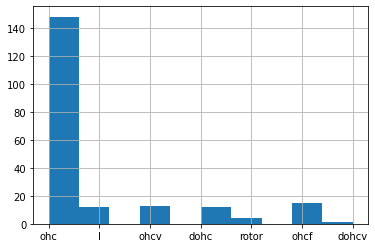

In [24]:

categorical_feature_names.append("engine-type")
look_at_feature(car_data["engine-type"])


16      six
24     four
113    four
53     four
125    four
Name: num-cylinders, dtype: object
0      four
103     six
91     four
43     four
27     four
Name: num-cylinders, dtype: object


count      205
unique       7
top       four
freq       159
Name: num-cylinders, dtype: object

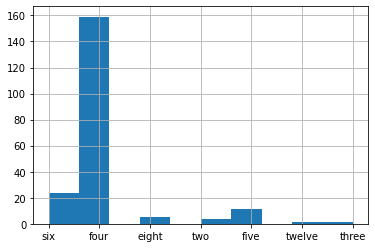

In [25]:

categorical_feature_names.append("num-cylinders")
look_at_feature(car_data["num-cylinders"])


16     209
24      90
113    120
53      91
125    151
Name: engine-size, dtype: int64
0      130
103    181
91      97
43     111
27      98
Name: engine-size, dtype: int64


count   205.00
mean    126.91
std      41.64
min      61.00
25%      97.00
50%     120.00
75%     141.00
max     326.00
Name: engine-size, dtype: float64

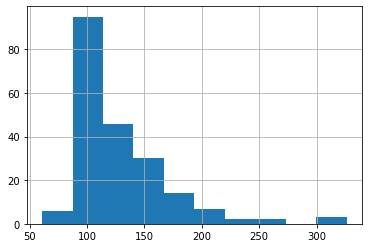

In [26]:

numeric_feature_names.append("engine-size")
look_at_feature(car_data["engine-size"])


16     mpfi
24     2bbl
113    mpfi
53     2bbl
125    mpfi
Name: fuel-system, dtype: object
0      mpfi
103    mpfi
91     2bbl
43     2bbl
27     mpfi
Name: fuel-system, dtype: object


count      205
unique       8
top       mpfi
freq        94
Name: fuel-system, dtype: object

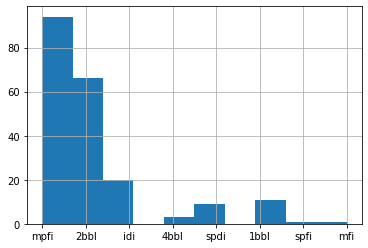

In [27]:

categorical_feature_names.append("fuel-system")
look_at_feature(car_data["fuel-system"])


16     3.62
24     2.97
113    3.46
53     3.03
125    3.94
Name: bore, dtype: object
0      3.47
103    3.43
91     3.15
43     3.31
27     3.03
Name: bore, dtype: object


count      205
unique      39
top       3.62
freq        23
Name: bore, dtype: object

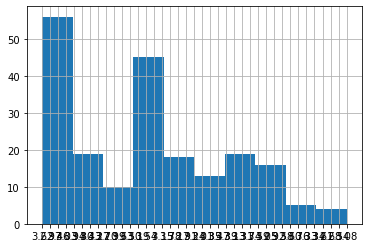

In [28]:

numeric_feature_names.append("bore")
look_at_feature(car_data["bore"])


16     3.39
24     3.23
113    2.19
53     3.15
125    3.11
Name: stroke, dtype: object
0      2.68
103    3.27
91     3.29
43     3.23
27     3.39
Name: stroke, dtype: object


count      205
unique      37
top       3.40
freq        20
Name: stroke, dtype: object

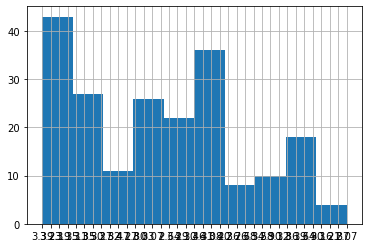

In [29]:

numeric_feature_names.append("stroke")
look_at_feature(car_data["stroke"])


16    8.00
24    9.40
113   8.40
53    9.00
125   9.50
Name: compression-ratio, dtype: float64
0     9.00
103   9.00
91    9.40
43    8.50
27    7.60
Name: compression-ratio, dtype: float64


count   205.00
mean     10.14
std       3.97
min       7.00
25%       8.60
50%       9.00
75%       9.40
max      23.00
Name: compression-ratio, dtype: float64

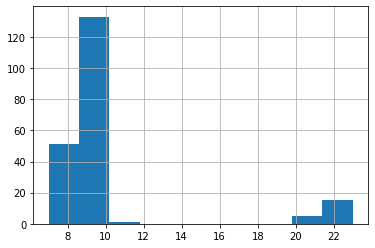

In [30]:

numeric_feature_names.append("compression-ratio")
look_at_feature(car_data["compression-ratio"])


16     182
24      68
113     95
53      68
125    143
Name: horsepower, dtype: object
0      111
103    152
91      69
43      78
27     102
Name: horsepower, dtype: object


count     205
unique     60
top        68
freq       19
Name: horsepower, dtype: object

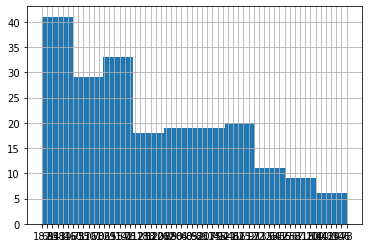

In [31]:

numeric_feature_names.append("horsepower")
look_at_feature(car_data["horsepower"])


16     5400
24     5500
113    5000
53     5000
125    5500
Name: peak-rpm, dtype: object
0      5000
103    5200
91     5200
43     4800
27     5500
Name: peak-rpm, dtype: object


count      205
unique      24
top       5500
freq        37
Name: peak-rpm, dtype: object

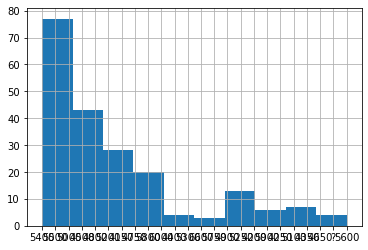

In [32]:

numeric_feature_names.append("peak-rpm")
look_at_feature(car_data["peak-rpm"])


16     16
24     31
113    19
53     31
125    19
Name: city-mpg, dtype: int64
0      21
103    19
91     31
43     24
27     24
Name: city-mpg, dtype: int64


count   205.00
mean     25.22
std       6.54
min      13.00
25%      19.00
50%      24.00
75%      30.00
max      49.00
Name: city-mpg, dtype: float64

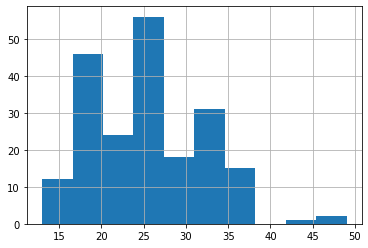

In [33]:

numeric_feature_names.append("city-mpg")
look_at_feature(car_data["city-mpg"])

16     22
24     38
113    24
53     38
125    27
Name: highway-mpg, dtype: int64
0      27
103    25
91     37
43     29
27     30
Name: highway-mpg, dtype: int64


count   205.00
mean     30.75
std       6.89
min      16.00
25%      25.00
50%      30.00
75%      34.00
max      54.00
Name: highway-mpg, dtype: float64

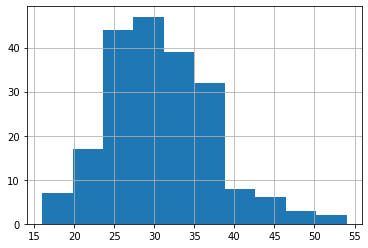

In [34]:
numeric_feature_names.append("highway-mpg")
look_at_feature(car_data["highway-mpg"])


In [35]:
print(numeric_feature_names)
print(len(numeric_feature_names))
print(categorical_feature_names)
print(len(categorical_feature_names))
# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

['symboling', 'normalized-losses', 'wheel-bases', 'length', 'width', 'height', 'weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']
15
['make', 'fuel-type', 'aspiration', 'num-doors', 'body-style', 'drive-wheels', 'engine-locations', 'engine-type', 'num-cylinders', 'fuel-system']
10


In [36]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
LABEL = "price"
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [37]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
16,0,?,103.50,193.80,67.90,53.70,3380,209,182,5400,16,22,3.62,3.39,8.00
24,1,148,93.70,157.30,63.80,50.60,1967,90,68,5500,31,38,2.97,3.23,9.40
113,0,?,114.20,198.90,68.40,56.70,3285,120,95,5000,19,24,3.46,2.19,8.40
53,1,113,93.10,166.80,64.20,54.10,1945,91,68,5000,31,38,3.03,3.15,9.00
125,3,186,94.50,168.90,68.30,50.20,2778,151,143,5500,19,27,3.94,3.11,9.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,?,88.60,168.80,64.10,48.80,2548,130,111,5000,21,27,3.47,2.68,9.00
103,0,108,100.40,184.60,66.50,55.10,3060,181,152,5200,19,25,3.43,3.27,9.00
91,1,128,94.50,165.30,63.80,54.50,1918,97,69,5200,31,37,3.15,3.29,9.40
43,0,?,94.30,170.70,61.80,53.50,2337,111,78,4800,24,29,3.31,3.23,8.50


In [38]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,aspiration,num-doors,engine-location,engine-type,num-cylinders,make,fuel-type,drive-wheels,body-style,fuel-system
16,std,two,front,ohc,six,bmw,gas,rwd,sedan,mpfi
24,std,four,front,ohc,four,dodge,gas,fwd,hatchback,2bbl
113,std,four,front,l,four,peugot,gas,rwd,wagon,mpfi
53,std,four,front,ohc,four,mazda,gas,fwd,sedan,2bbl
125,std,two,front,ohc,four,porsche,gas,rwd,hatchback,mpfi
...,...,...,...,...,...,...,...,...,...,...
0,std,two,front,dohc,four,alfa-romero,gas,rwd,convertible,mpfi
103,std,four,front,ohcv,six,nissan,gas,fwd,sedan,mpfi
91,std,two,front,ohc,four,nissan,gas,fwd,sedan,2bbl
43,std,four,front,ohc,four,isuzu,gas,rwd,sedan,2bbl


In [39]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [40]:
# This code "works", but because of bad hyperparameter choices it gets NaN loss
# during training. Try fixing this.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=

In [41]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


In [42]:



def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 2
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 6
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvj77wctu/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


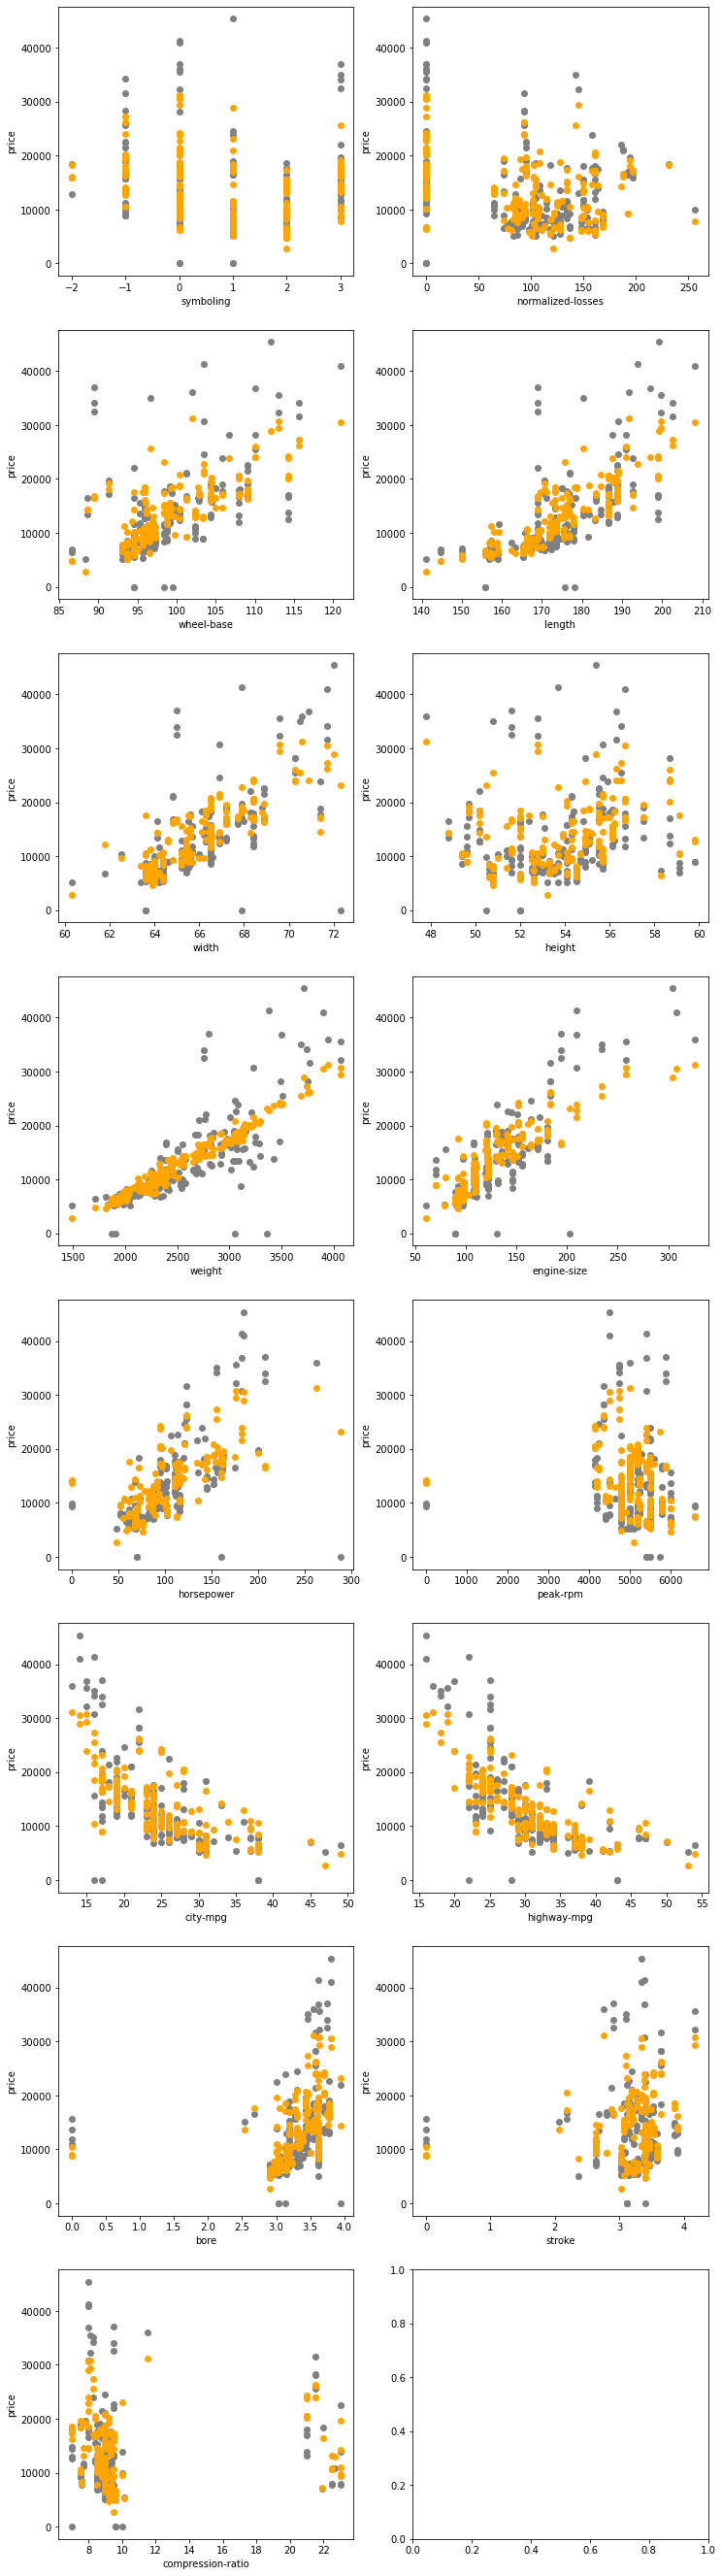

In [43]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

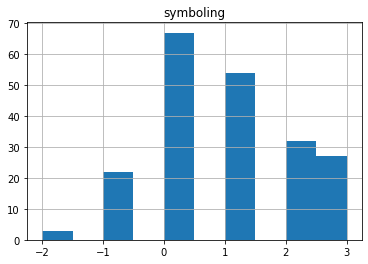

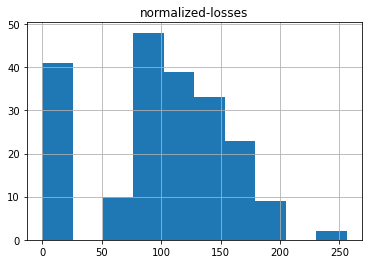

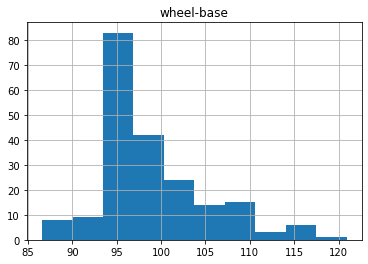

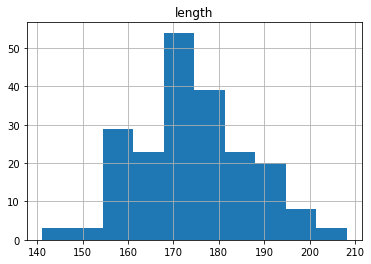

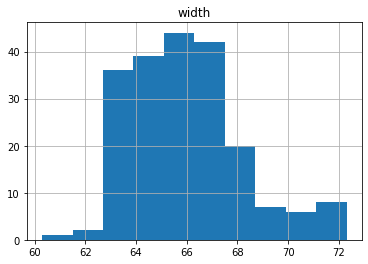

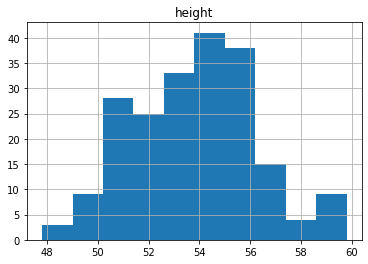

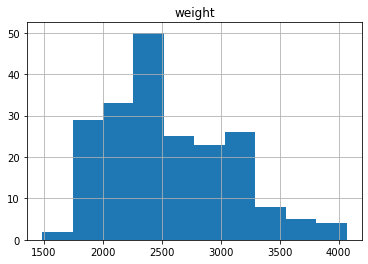

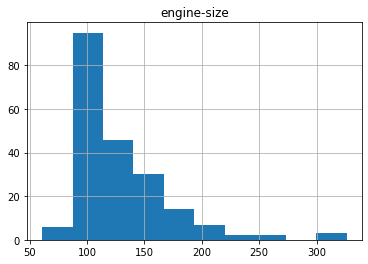

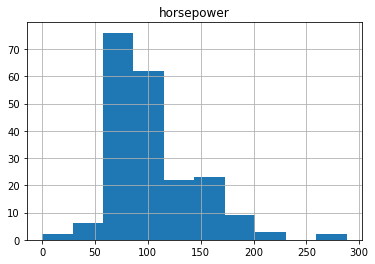

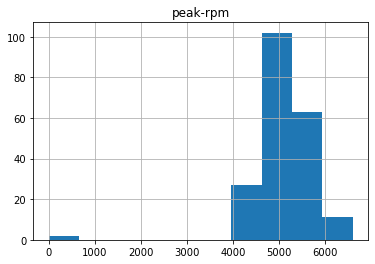

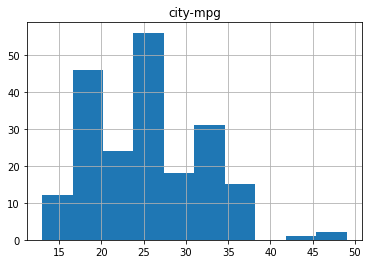

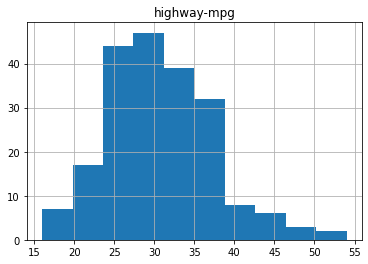

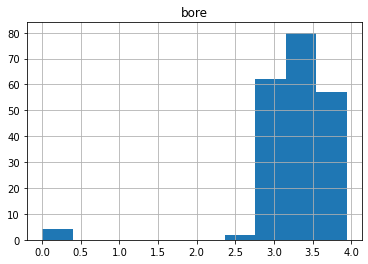

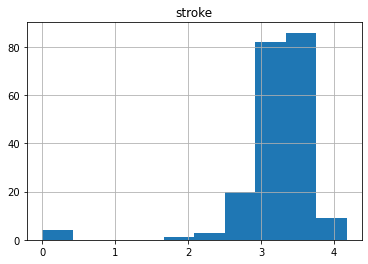

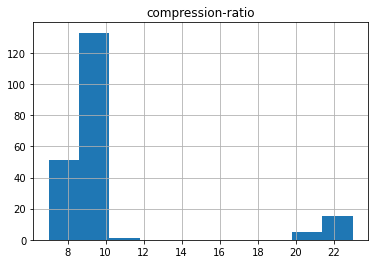

In [44]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [45]:
def make_score_plot(all_scores):
  # get data in right format
  # could add a sort by x_label but we'll trust the data for now
  x_label = "global_step"
  x = [scores["global_step"] for scores in all_scores]
  y_labels = [key for key in all_scores[0]]
  y_labels.remove("global_step")
  y_s = {
      label: [scores[label] for scores in all_scores]
      for label in y_labels
  }

  y_s["average_loss"] = [x/(10**6) for x in y_s["average_loss"]]
  plt.plot(x, y_s["average_loss"], label = "average_loss" + " (/10^6)")

  y_s["loss"] = [x/(10**7) for x in y_s["loss"]]
  plt.plot(x, y_s["loss"], label = "loss" + " (/10^7)")

  for label, stats in y_s.items():
    print(label)
    print(stats)
  
  # plt.xlabel('x - axis')
  # plt.ylabel('y - axis')
  plt.title('scores')
  plt.legend()

Start by normalizing all feature using their Z-scores

think about
- bucketting (symboling?)
- using mean for nulls
- non linear relationships (plot price vs feature)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e38a4950>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e38a49e0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e38a4c20>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e38a4cb0>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e38a4e60>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

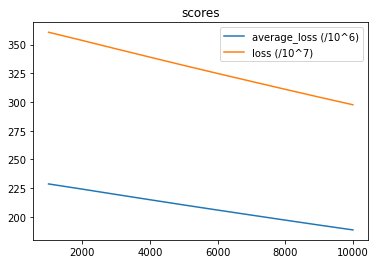

In [46]:
batch_size = 16
means = car_data.mean()[numeric_feature_names]
stds = car_data.std()[numeric_feature_names]

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / stds[feature_name]

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxnozzc93/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


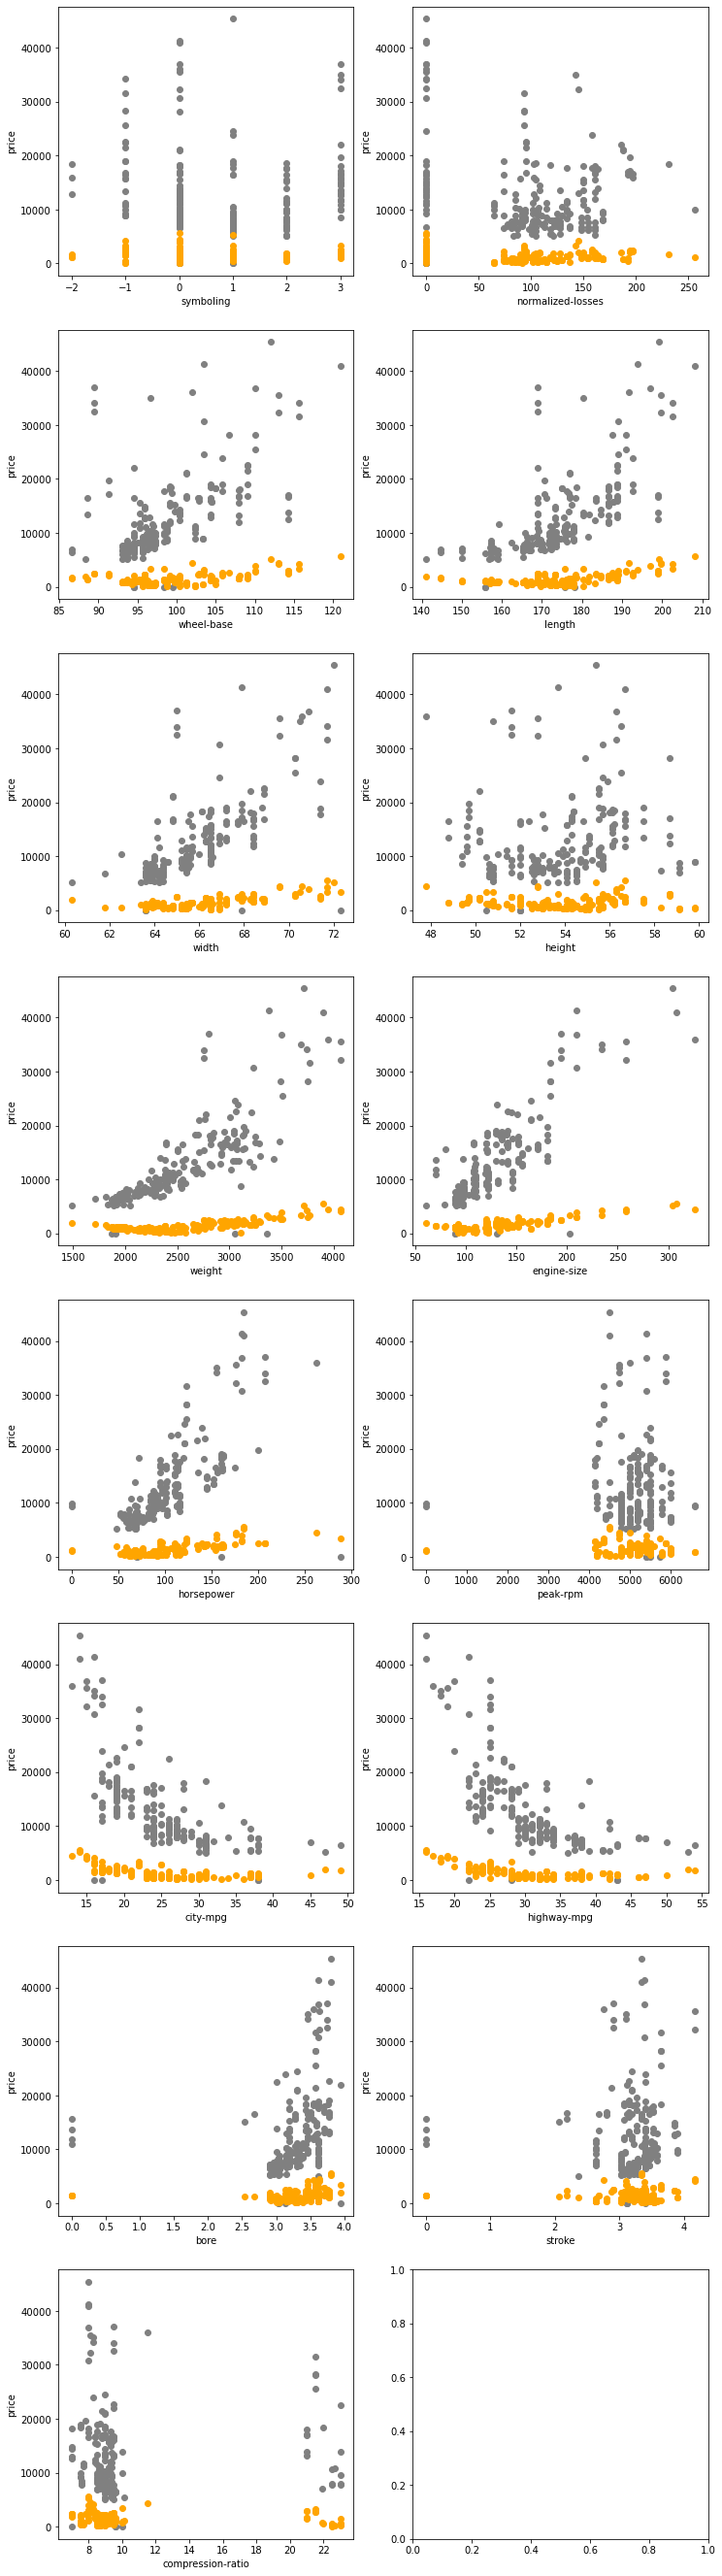

In [47]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [48]:
transformed = (car_data['length'] - means['length'] ) / stds['length']
print(transformed.describe())
transformed

count   205.00
mean     -0.00
std       1.00
min      -2.67
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64


16     1.60
24    -1.36
113    2.01
53    -0.59
125   -0.42
       ... 
0     -0.43
103    0.86
91    -0.71
43    -0.27
27    -1.36
Name: length, Length: 205, dtype: float64

In [49]:
# There's an issue with this model
# I didn't add an epsilon to avoid divide by zero
# how can I see in the data that this has happend?

# div_by_0 = car_data['length'] / 0
# print(div_by_0)

# divide by zero causes `inf` in pandas. This would cause a LOT of squew!

# why didn't I see this when using describe?

# print(div_by_0.describe())

transform_all_numberic_features = (x_df - means) / stds
print(transform_all_numberic_features)
transform_all_numberic_features.describe()

# based on the describe feature it doesn't seem like there are any inf cause by
# not including epsilon = 0.000001
# I would expect adding epsilon not to make a difference to the model

     symboling  normalized-losses  wheel-base  length  width  height  weight  \
16       -0.67              -1.67        0.79    1.60   0.93   -0.01    1.58   
24        0.13               0.86       -0.84   -1.36  -0.98   -1.28   -1.13   
113      -0.67              -1.67        2.56    2.01   1.16    1.22    1.40   
53        0.13               0.26       -0.94   -0.59  -0.80    0.15   -1.17   
125       1.74               1.52       -0.71   -0.42   1.12   -1.44    0.43   
..         ...                ...         ...     ...    ...     ...     ...   
0         1.74              -1.67       -1.69   -0.43  -0.84   -2.02   -0.01   
103      -0.67               0.18        0.27    0.86   0.28    0.56    0.97   
91        0.13               0.52       -0.71   -0.71  -0.98    0.32   -1.22   
43       -0.67              -1.67       -0.74   -0.27  -1.91   -0.09   -0.42   
27        0.13               0.86       -0.84   -1.36  -0.98   -1.28   -0.70   

     engine-size  horsepower  peak-rpm 

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.28,-1.67,-2.02,-2.67,-2.61,-2.42,-2.05,-1.58,-2.53,-7.31,-1.87,-2.14,-6.10,-5.81,-0.79
25%,-0.67,-0.35,-0.71,-0.63,-0.84,-0.71,-0.79,-0.72,-0.81,-0.40,-0.95,-0.84,-0.25,-0.17,-0.39
50%,0.13,0.09,-0.29,-0.07,-0.19,0.15,-0.27,-0.17,-0.20,0.18,-0.19,-0.11,0.08,0.18,-0.29
75%,0.94,0.68,0.61,0.73,0.46,0.73,0.73,0.34,0.31,0.61,0.73,0.47,0.59,0.40,-0.19
max,1.74,2.72,3.68,2.76,2.98,2.49,2.90,4.78,4.52,2.19,3.63,3.38,1.26,1.78,3.24


In [50]:
epsilon = 0.000001

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f521ff129e0>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f520421c710>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f520421c7a0>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f520421c830>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f520421c8c0>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

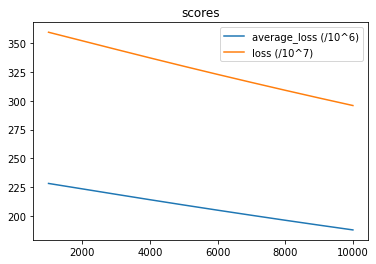

In [51]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        # normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name])
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpzuf3ya4i/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


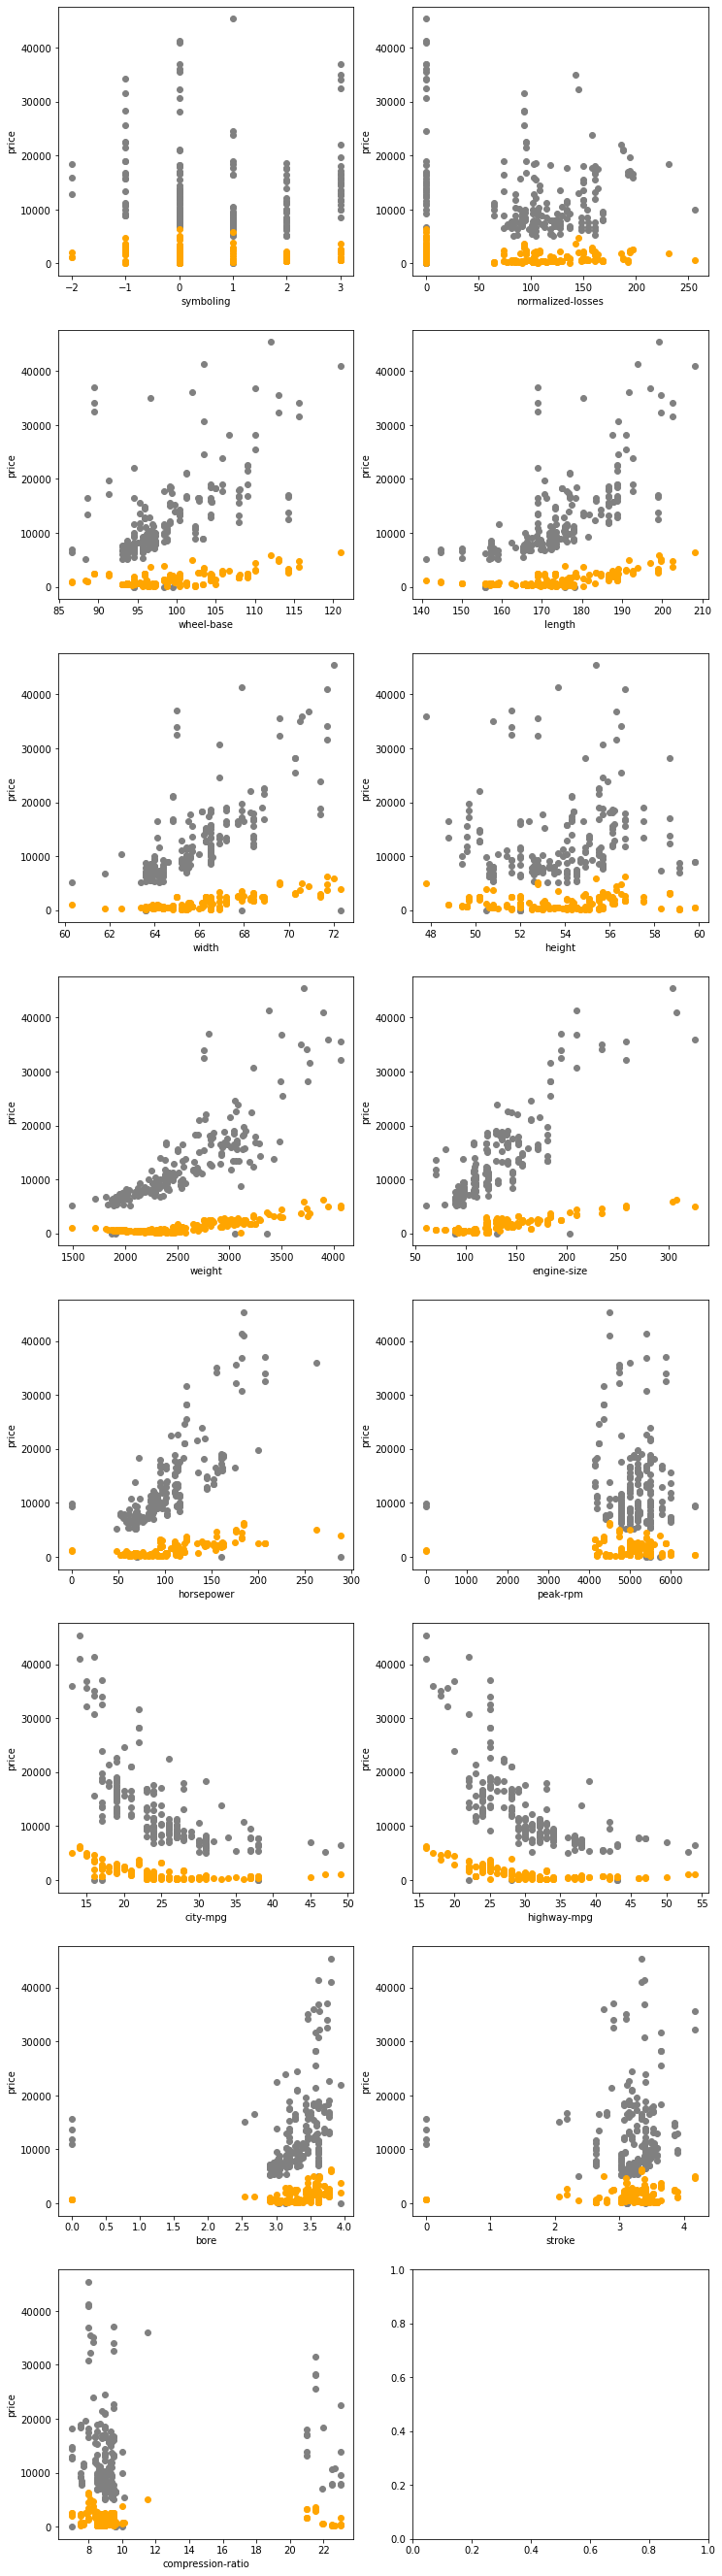

In [52]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [53]:
# epsilon is good to remember but it doesn't look like it was the issue

# How would I know if there was an inf in my data set?


means_length = (x_df['length'] - means['length']) / stds['length']
means_length[0] /= 0
means_length.describe()
# if there was an `inf` it would show up in the describe
# takehomes
# 1. use the describe when making transformations, easy way to catch a mistake
# 2. div by zero is DANGEROUS!!! Common Ian, why don't you remember that!

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


count   205.00
mean      -inf
std        nan
min       -inf
25%      -0.63
50%      -0.07
75%       0.73
max       2.76
Name: length, dtype: float64

In [54]:
# TODO What is the next thing my error could be caused by?
# the only difference seems to be the lambda.
# I switched the def for the lambda and it's working

# I'm worried that the lambda and the def have different scoping rules
# (I don't know python very well)

def generate_numberic_feature_normalizer(feature_name):
  return lambda x: {"mean": x_df.mean()[feature_name], "std": epsilon + x_df.std()[feature_name]}

def_normalizers = dict()
lambda_normalizers = dict()
for feature_name in numeric_feature_names:
  def_normalizers[feature_name] = generate_numberic_feature_normalizer(feature_name)
  lambda_normalizers[feature_name] = lambda val: {"mean": x_df.mean()[feature_name], "std": epsilon + x_df.std()[feature_name]}

for key in def_normalizers:
  print(key, ':')
  print('  def :', def_normalizers[key](1))
  print('  lambda :', lambda_normalizers[key](1))
  print('  should be :', {"mean": car_data.mean()[key], "std": car_data.std()[key]})

# it seems that the scoping isn't the issue but instead the for loop.
# The last value of the for loop is used as the value of feature_name each time the lambda is called

symboling :
  def : {'mean': 0.8341463414634146, 'std': 1.2453078281055303}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632964}
  should be : {'mean': 0.8341463414634146, 'std': 1.2453068281055304}
normalized-losses :
  def : {'mean': 97.6, 'std': 58.282073715372796}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632964}
  should be : {'mean': 97.6, 'std': 58.2820727153728}
wheel-base :
  def : {'mean': 98.75658536585364, 'std': 6.02177668502557}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632964}
  should be : {'mean': 98.75658536585364, 'std': 6.0217756850255695}
length :
  def : {'mean': 174.04926829268297, 'std': 12.337289526555175}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632964}
  should be : {'mean': 174.04926829268297, 'std': 12.337288526555175}
width :
  def : {'mean': 65.90780487804876, 'std': 2.1452048526871828}
  lambda : {'mean': 10.142536585365855, 'std': 3.9720413218632964}
  should be : {'mean': 65.907804878048

In [55]:
# the question still remains, why does this perform so poorly?
# especially over a model that is doing a random transform ('mean': 10.14, 'std': 3.97) for everything

# I'll try normalizing feature one at a time instead of all at once

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

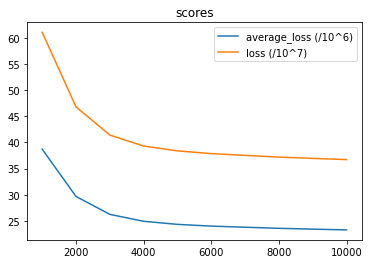

In [56]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = []
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='peak-rpm', shape=(1,), default_value=None

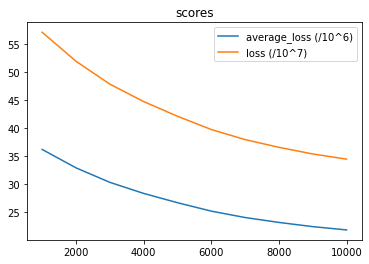

In [57]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = ["peak-rpm"]
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.02),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

I noticed that the graph wasn't shaped like the first one and thought about learning rate. I wondered if learning rate would need to increase as normalization was put in place.

I'm going to try one more normalizing one more feature this way then go back to normalizing all of them and adjusting the learning rate

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3e764d0>), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='horsepower', shape=(1,), default_value=None, dtype=tf.float32, no

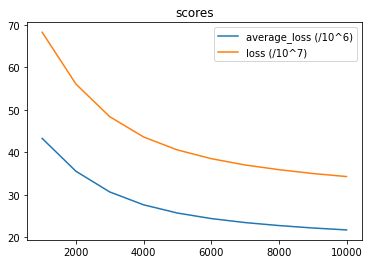

In [58]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = []
numeric_feature_to_normalize = ["peak-rpm", "weight"]
for feature_name in numeric_feature_names:
  normalizer_fn = None
  if feature_name in numeric_feature_to_normalize:
    normalizer_fn=generate_numberic_feature_normalizer(feature_name)

  model_feature_columns.append(
     tf.feature_column.numeric_column(
          feature_name,
          normalizer_fn=normalizer_fn
        ))

print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.02),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3b14680>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3b143b0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3b14560>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3b144d0>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f51e3b149e0>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

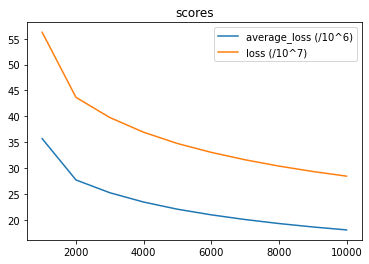

In [59]:
batch_size = 16

x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjq_c5b1y/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


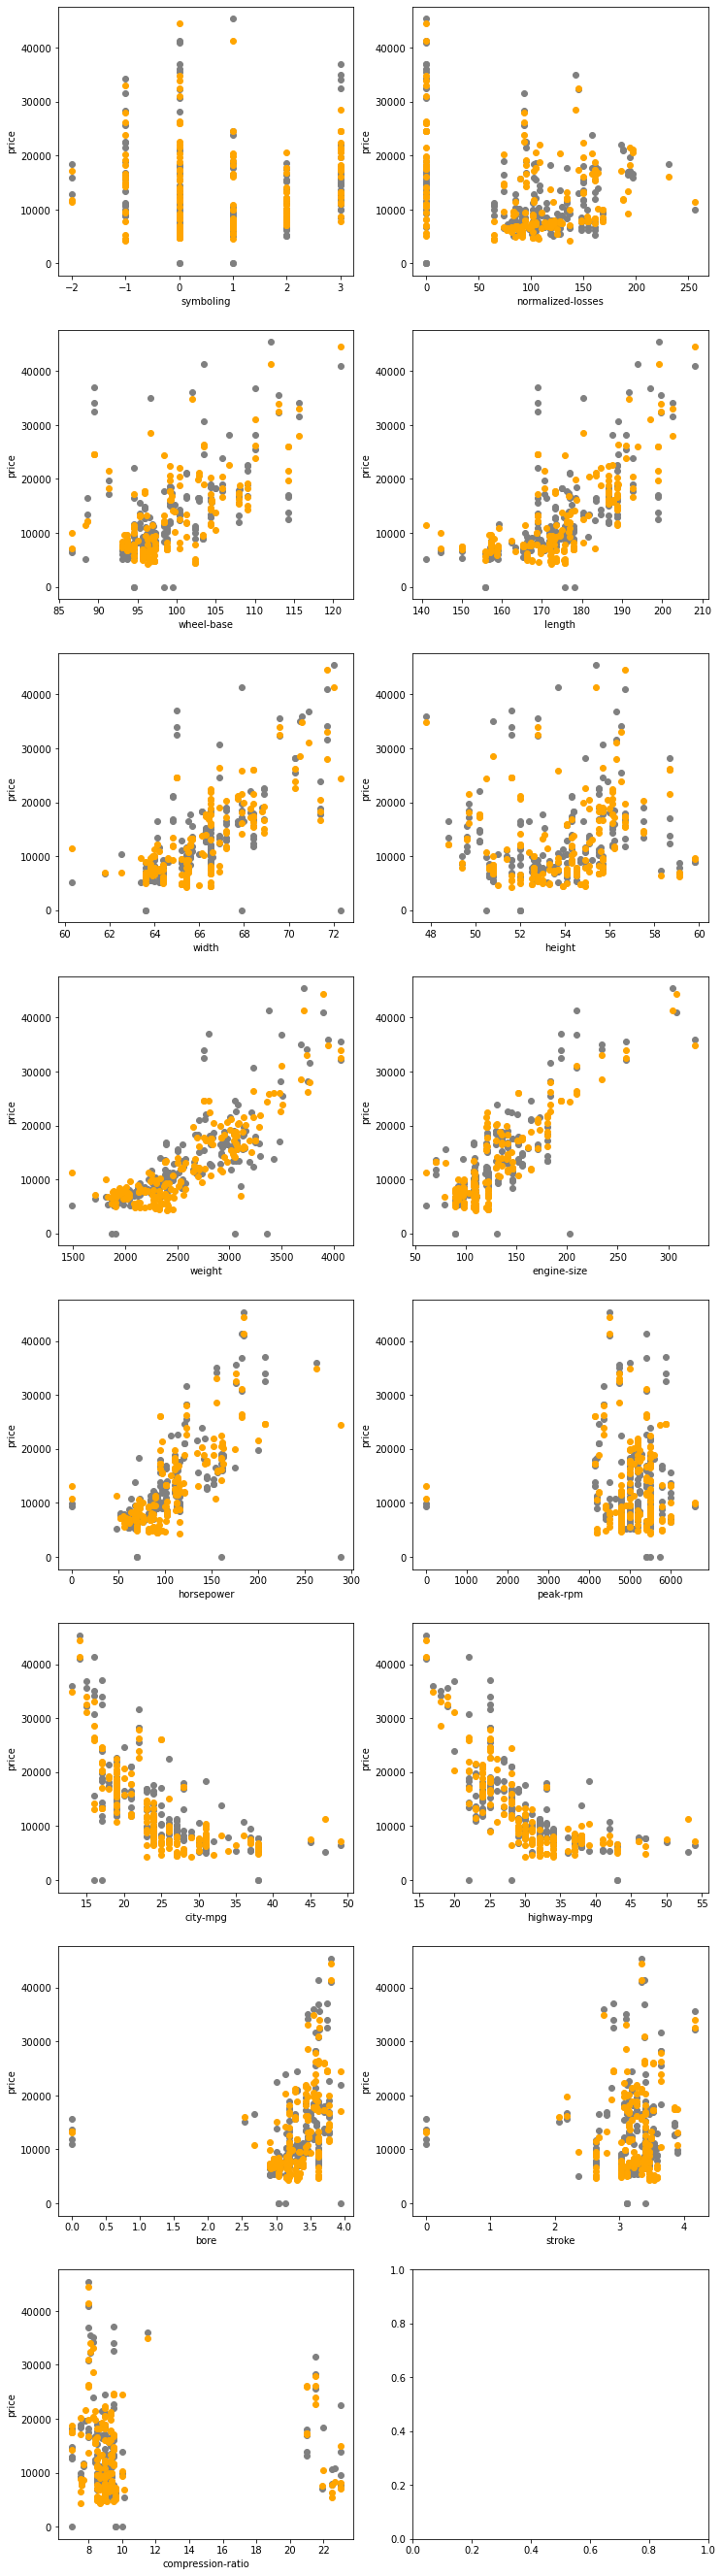

In [60]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

normalizing everything and bumping up the learning rate really improved the model performance

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f51e3e3ee60>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f51e3e3ecb0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f51e3e3ec20>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f51e3e3eb90>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f51e3e3eb00>), NumericColumn(key='height', shape=(1,), default_va

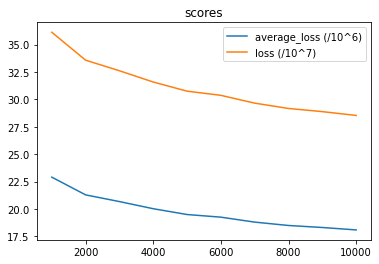

In [61]:
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  # The `scores` dictionary has several metrics automatically generated by the 
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)
  all_scores.append(scores)

make_score_plot(all_scores)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8ijybyk5/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


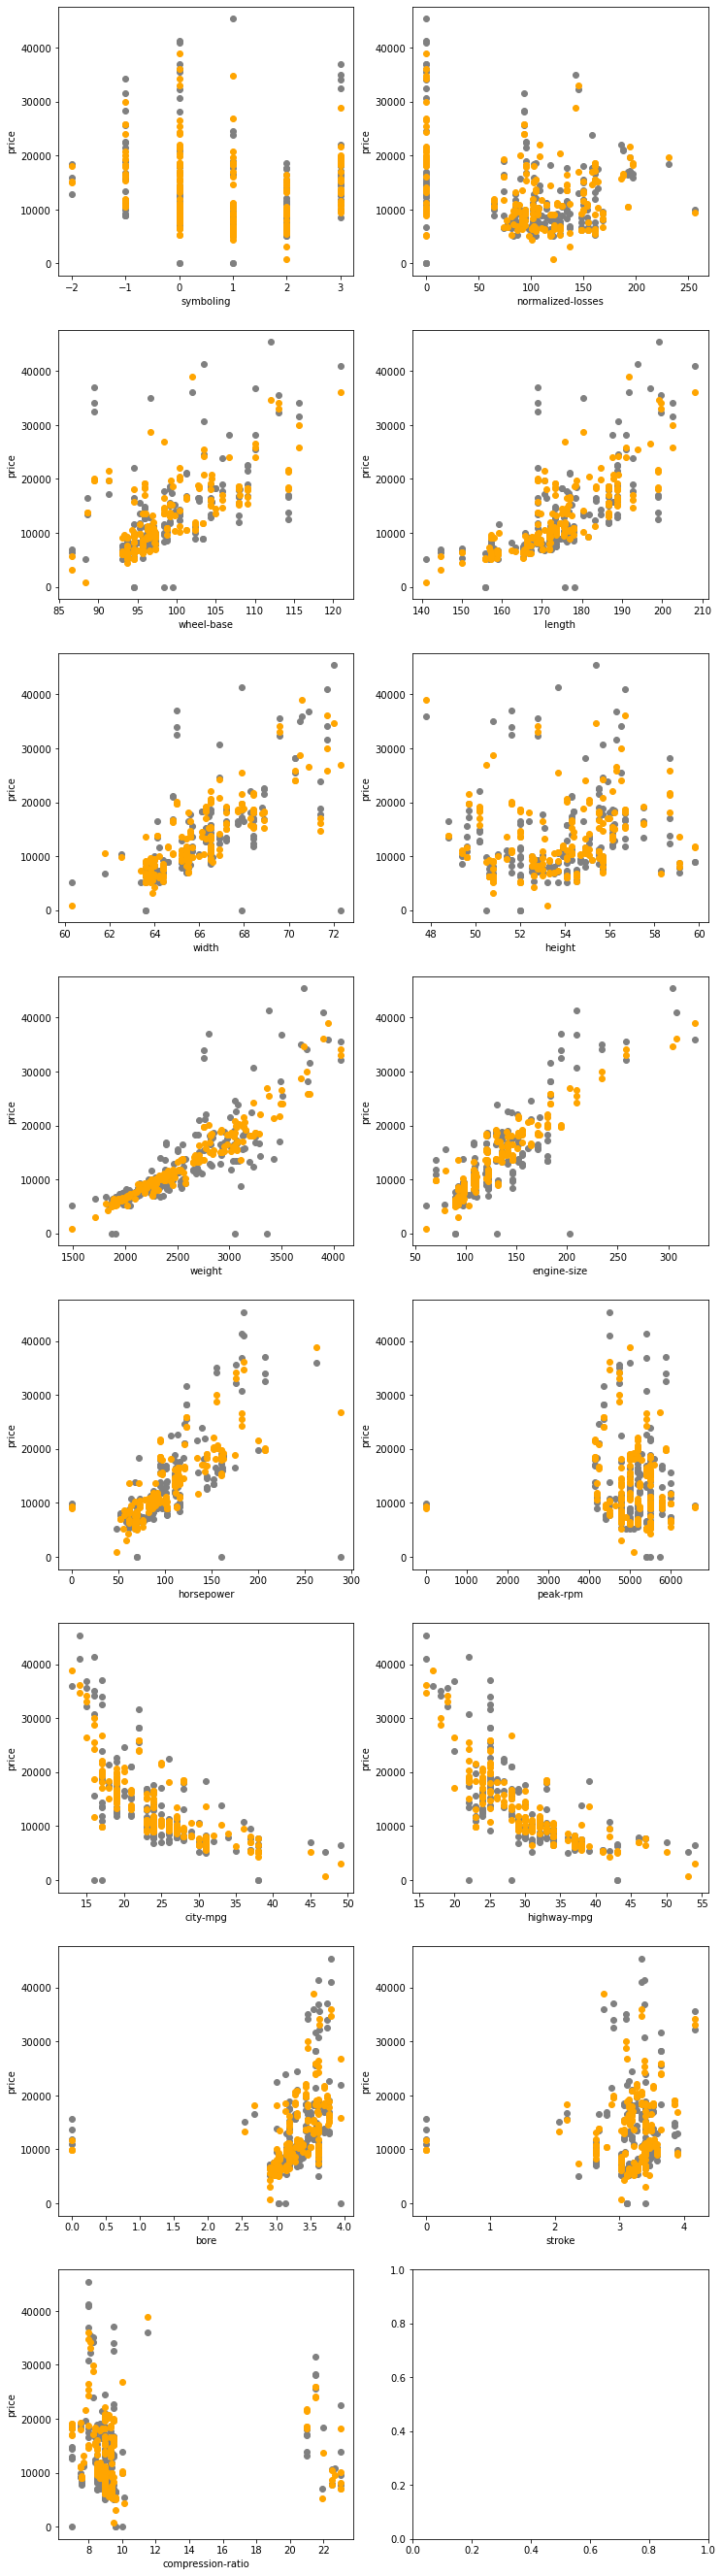

In [62]:
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

In [63]:
# # attempting to implement the GradientDescentOptimizer

# batch_size = 16

# x_df = car_data[numeric_feature_names]
# y_series = car_data['price']

# # Create input_fn's so that the estimator knows how to read in your data.
# train_input_fn = tf.estimator.inputs.pandas_input_fn(
#     x=x_df,
#     y=y_series,
#     batch_size=batch_size,
#     num_epochs=None,
#     shuffle=True)

# eval_input_fn = tf.estimator.inputs.pandas_input_fn(
#     x=x_df,
#     y=y_series,
#     batch_size=batch_size,
#     shuffle=False)

# predict_input_fn = tf.estimator.inputs.pandas_input_fn(
#     x=x_df,
#     batch_size=batch_size,
#     shuffle=False)

# # Feature columns allow the model to parse the data, perform common
# # preprocessing, and automatically generate an input layer for the tf.Estimator.
# means = x_df.mean()
# stds = x_df.std()
# def generate_numberic_feature_normalizer(feature_name):
#   return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

# model_feature_columns = [
#     tf.feature_column.numeric_column(
#         feature_name,
#         normalizer_fn=generate_numberic_feature_normalizer(feature_name)
#         )
#     for feature_name in numeric_feature_names
# ]
# print('model_feature_columns', model_feature_columns)

# est = tf.estimator.DNNRegressor(
#     feature_columns=model_feature_columns,
#     hidden_units=[64],
#     optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
#   )

# # TRAIN
# num_print_statements = 10
# num_training_steps = 10000
# all_scores = []
# for _ in range(num_print_statements):
#   est.train(train_input_fn, steps=num_training_steps // num_print_statements)
#   scores = est.evaluate(eval_input_fn)

#   all_scores.append(scores)
#   print('scores:', scores)

# make_score_plot(all_scores)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [64]:
# what are the values in each column
for feature_name in categorical_feature_names:
    print(feature_name, ': ', car_data[feature_name].unique())

aspiration :  ['std' 'turbo']
num-doors :  ['two' 'four' '?']
engine-location :  ['front' 'rear']
engine-type :  ['ohc' 'l' 'ohcv' 'dohc' 'rotor' 'ohcf' 'dohcv']
num-cylinders :  ['six' 'four' 'eight' 'two' 'five' 'twelve' 'three']
make :  ['bmw' 'dodge' 'peugot' 'mazda' 'porsche' 'mercedes-benz' 'toyota'
 'nissan' 'jaguar' 'saab' 'subaru' 'volvo' 'mitsubishi' 'plymouth' 'honda'
 'volkswagen' 'audi' 'alfa-romero' 'isuzu' 'mercury' 'chevrolet' 'renault']
fuel-type :  ['gas' 'diesel']
drive-wheels :  ['rwd' 'fwd' '4wd']
body-style :  ['sedan' 'hatchback' 'wagon' 'hardtop' 'convertible']
fuel-system :  ['mpfi' '2bbl' 'idi' '4bbl' 'spdi' '1bbl' 'spfi' 'mfi']


In [65]:
# how many of each value are there?
car_data[categorical_feature_names].describe()

,aspiration,num-doors,engine-location,engine-type,num-cylinders,make,fuel-type,drive-wheels,body-style,fuel-system
count,205,205,205,205,205,205,205,205,205,205
unique,2,3,2,7,7,22,2,3,5,8
top,std,four,front,ohc,four,toyota,gas,fwd,sedan,mpfi
freq,168,114,202,148,159,32,185,120,96,94


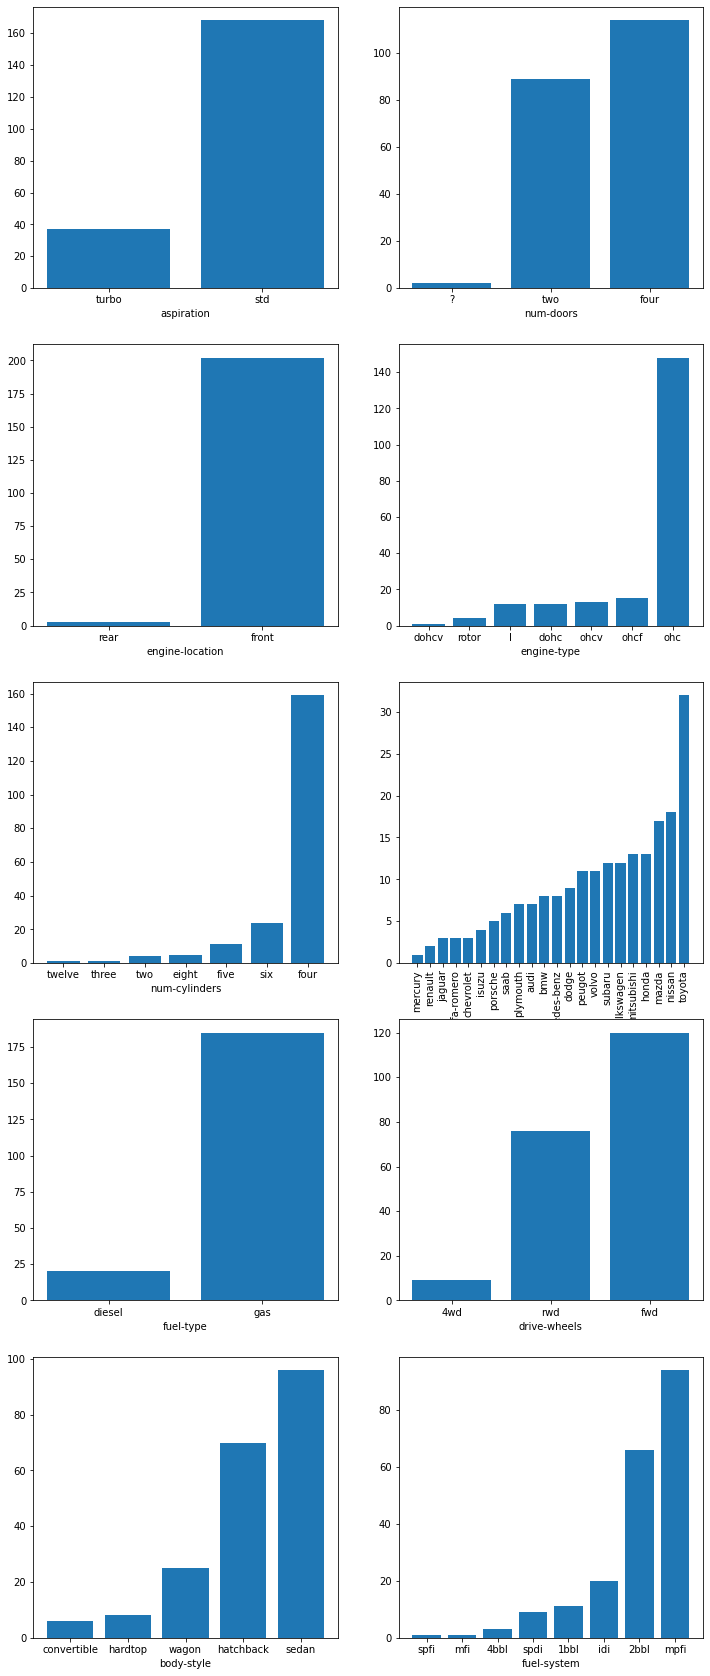

In [66]:
from matplotlib import pyplot as plt
num_cols = 2
num_rows = int(math.ceil(len(categorical_feature_names)/float(num_cols)))
f, axarr = plt.subplots(num_rows, num_cols)
size = 6
f.set_size_inches(num_cols*size, num_rows*size)


for i, feature_name in enumerate(categorical_feature_names):
    values = car_data[feature_name]
    value_count = {}
    
    for value in values:
        if value not in value_count:
            value_count[value] = 0
        value_count[value] += 1
    
    unique_values = sorted(list(value_count.keys()), key=lambda value: value_count[value])
    axis = axarr[int(i/num_cols), i%num_cols]
    axis.set_xlabel(feature_name)
    
    if feature_name == "make":
        axis.tick_params('x', labelrotation=90)
    
    axis.bar(unique_values, list(map(lambda value: value_count[value], unique_values)))

plt.show()

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('std', 'turbo'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'l', 'ohcv', 'dohc', 'rotor', 'ohcf', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('six', 'four', 'eight', 'two', 'five', 'twelve', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), Indicator

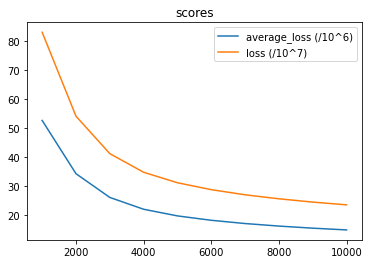

In [67]:
batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
        feature_name,
        vocabulary_list=x_df[feature_name].unique()
        ))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)


model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('std', 'turbo'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'l', 'ohcv', 'dohc', 'rotor', 'ohcf', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('six', 'four', 'eight', 'two', 'five', 'twelve', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), Indicator

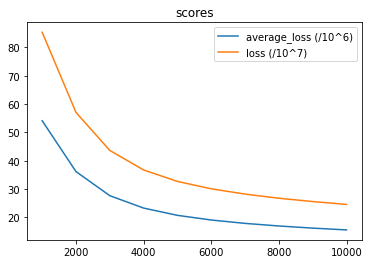

In [68]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)


## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f52040a3950>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f52040a33b0>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f52040a3cb0>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f52040a3710>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function generate_numberic_feature_normalizer.<locals>.<lambda> at 0x7f52040a3dd0>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.f

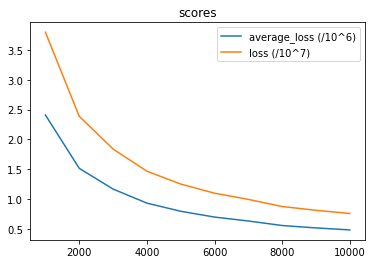

In [69]:
## Your code goes here
batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

# Create input_fn's so that the estimator knows how to read in your data.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# preprocessing, and automatically generate an input layer for the tf.Estimator.
means = x_df.mean()
stds = x_df.std()
def generate_numberic_feature_normalizer(feature_name):
  return lambda x: (x - means[feature_name]) / (epsilon + stds[feature_name])

model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=generate_numberic_feature_normalizer(feature_name)
        )
    for feature_name in numeric_feature_names
] + [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name,
            vocabulary_list=x_df[feature_name].unique()
            ))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=1),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)


model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('std', 'turbo'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('two', 'four', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-location', vocabulary_list=('front', 'rear'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'l', 'ohcv', 'dohc', 'rotor', 'ohcf', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('six', 'four', 'eight', 'two', 'five', 'twelve', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), Indicator

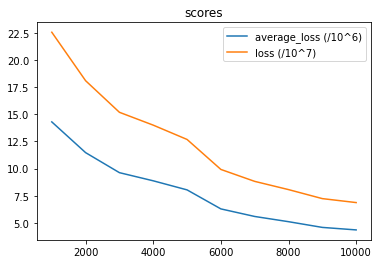

In [70]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
all_scores = []
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  
  all_scores.append(scores)
  print('scores:', scores)

make_score_plot(all_scores)


# Concusion

- combining features can have a drastic impact on model learning
    average loss:
        categorical: 16,517,922
        numerical: 17,288,228
        both: 453,648
- visualizing feature and outputs greatly speeds up understanding of the data

Questions
- How can I speed up model development?
    - Are there better ways to understand features and their relationships to eachother and the target? (graphing, PCA, others?)
    - Does it make sense to run multiple training jobs symultaniously and look at the outputs?
    - It seems like there should be a model or heuristic for choosing hyperparameters
- How can you tell which features are valuable to keep and which aren't?
- How do you know which models to use for a given case
